In [1]:
include("../src/celerite.jl")
include("../TransitModel/transit.jl")
using Plots
using Statistics
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using DelimitedFiles

In [2]:
function make_gp(t, log_s, log_w0, log_var; bins=nothing, A0=nothing, ds0dlam=1, c=nothing)
    if bins != nothing 
        f = [sum(bins[1:i]) for i in 0:length(bins)]
        var = [exp(log_var)/b for b in bins]
        if c == nothing
            c = [(A0+ds0dlam*(f[i+1]+f[i]))/(A0+ds0dlam*(2*sum(f[2:end-1])+1)) for i in 1:length(bins)]*length(bins)
        else
            c = c./mean(c)
        end
        m = length(c)
        Q = broadcast(*, c, c')
        wn_vec = zeros(length(t)*m)
        for i in 1:m
            wn_vec[i:m:end] .= sqrt.(var[i]) 
        end
    else
        Q = ones(1, 1)
        c = nothing
    end
    log_q = log(1/sqrt(2))
    if bins != nothing
        gp = celerite.Celerite(celerite.SHOTerm(log_s, log_q, log_w0), Q)
        logD = celerite.compute!(gp, t, wn_vec)
    else
        gp = celerite.Celerite(celerite.SHOTerm(log_s, log_q, log_w0))
        logD = celerite.compute!(gp, t, exp.(0.5*log_var))
    end
    return gp, log_var, c
end

function trapezoidal_transit(t, t0, r, d, tin)
    trans = ones(length(t))
    t1 = (t0-d/2-tin)
    t2 = (t0-d/2)
    t3 = (t0+d/2)
    t4 = (t0+d/2+tin)
    intransit = (t.<=t3).&(t.>=t2)
    ingress = (t.<t2).&(t.>t1)
    egress = (t.<t4).&(t.>t3)
    
    if r > 0
        trans[intransit] .= 1-(r^2)
        trans[ingress] .= 1 .-(t[ingress].-t1)*(r^2)/tin
        trans[egress] .= (1 - (r^2)) .+(t[egress].-t3)*(r^2)/tin
    else
        trans[intransit] .= 1+(r^2)
        trans[ingress] .= 1 .+(t[ingress].-t1)*(r^2)/tin
        trans[egress] .= (1 + (r^2)) .-(t[egress].-t3)*(r^2)/tin
    end
    return trans
end

trapezoidal_transit (generic function with 1 method)

In [203]:
# define parameters for mcmc run 

t = collect(-4:0.01:4)

t0 = 0
b0 = 0
rp = 0.1
d = 0.5
tin = d/3
u = [0.5, 0.5]
x0 = [t0, rp, d, tin]
c2 = 2
log_total_var = -14
log10_amp_ratio = collect(-3:0.5:3)
log_amp_ratio = log.(10 .^(log10_amp_ratio))
log_sig = 0.5*log_total_var .- 0.5*log.(1 .+ exp.(2*log_amp_ratio))
log_corr_amp = log_amp_ratio + log_sig

w0T = 0.1
log_w0 = log(w0T) - log(d)
log_s0 = 2*(log_corr_amp)  .- log_w0

13-element Array{Float64,1}:
 -26.206073645529674
 -23.90349755248613 
 -21.601002454542414
 -19.29931686688112 
 -17.00568260440716 
 -14.788457360364273
 -13.083709268125846
 -12.485872267370226
 -12.400512418419067
 -12.391561587898984
 -12.390662082566234
 -12.390572087515901
 -12.3905630875654  

In [204]:
# simulate data for mcmc run
io_mono = open("mcmc_data/input/params_mono_1.in", "a")
io_poly = open("mcmc_data/input/params_poly_1.in", "a")
c = zeros(2)
for i in 1:length(log_sig)
    monogp, _, _ = make_gp(t, log_s0[i], log_w0, 2*log_sig[i]) 
    polygp, log_wn, c = make_gp(t, log_s0[i], log_w0, 2*log_sig[i], bins=[1/2, 1/2], c=[1, 2])
    monoy = celerite.simulate_gp(monogp, randn(length(t))) .+ trapezoidal_transit(t, x0...)
    polyy = celerite.simulate_gp(polygp, randn(2*length(t))) .+ kron(ones(2)',trapezoidal_transit(t, x0...))'
    writedlm("mcmc_data/input/transit_mono_1_$(i)", hcat(t, monoy))
    writedlm("mcmc_data/input/transit_poly_1_$(i)", hcat(t, polyy'))
    writedlm(io_mono, [log_sig[i], rp, d, tin, log_s0[i], 1/sqrt(2), log_w0, t0]')
    writedlm(io_poly, [sqrt(2)*log_sig[i], sqrt(2)*log_sig[i], 1.0, 2.0, rp, d, tin, log_s0[i], 1/sqrt(2), log_w0, t0]')
end
c1, c2 = c[1], c[2]
writedlm("mcmc_data/input/codes.in", collect(1:1:length(log_sig))')
close(io_mono)
close(io_poly)

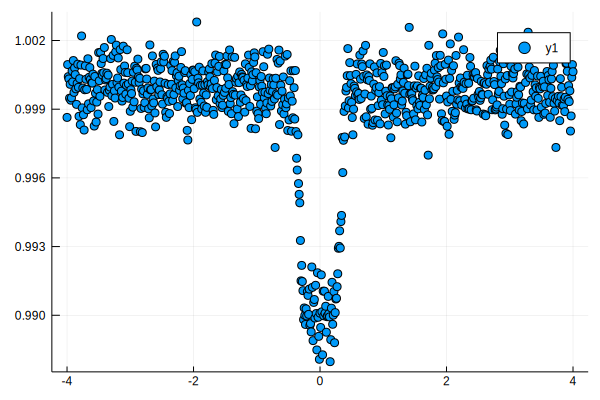

In [206]:
data = readdlm("mcmc_data/input/transit_mono_1_1")
#println(log_s[16])
t = data[:,1]
flux = data[:,2]
plot(t, flux, marker=:circle, linewidth=0)

[0.0, -0.1, 0.5, 0.166667]


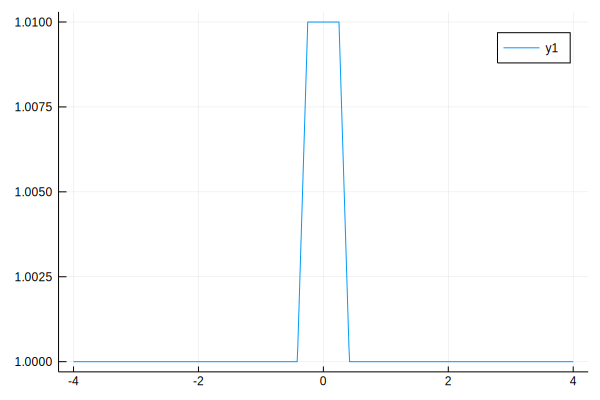

In [393]:
x0[2] = -0.1
println(x0)
plot(t, trapezoidal_transit(t, x0...))

In [289]:
gp, _, _ = make_gp(t, log_s-log_w0, log_w0, log_var[14])
t0 = collect(-0.1:0.001:0.1)
like = zeros(length(t0))
for (i, c) in enumerate(t0)
    x0[1] = c
    trans = transit(t, x0...)[1]
    r = flux-trans
    like[i] = celerite.log_likelihood(gp, r)
end

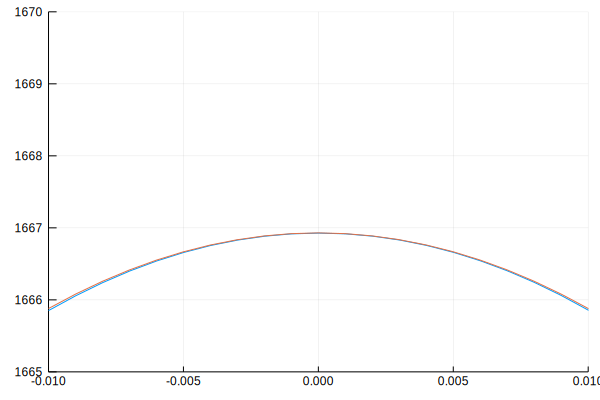

In [305]:
plot(t0, like, legend=false)
plot!(t0, 1666.93 .-10500*((t0).^2), xlims=(-0.01, 0.01), ylims=(1665, 1670))

In [320]:
fluxdata = readdlm("mcmc_data/short_timescale/input/transit_poly_1")
vec(permutedims(fluxdata[:, 2:end]))

1602-element Array{Float64,1}:
  0.00031228746328128824
 -0.0009610312456413734 
  0.0002774888437266673 
 -0.0005703354857029043 
  0.0007522363919591545 
 -0.0008333173560973878 
 -0.0006978418383064564 
 -0.00017571179828989786
  0.0002575690111348754 
 -0.00034625893672382487
 -0.00023626504290742115
 -0.00020164348621713233
 -0.0001874700890392283 
  ⋮                     
 -0.00041921594065674587
  0.0004931827154108803 
  0.000615666413124152  
 -0.00020536428712764884
  0.00013222766480153246
 -0.0003553194720960319 
 -0.0004348143924204774 
 -0.0006747546930730939 
  0.00023639836393008113
 -0.00020721545400795906
 -0.00010873503747679381
 -9.15710945359885e-5   

In [321]:
fluxdata

801×3 Array{Float64,2}:
 -4.0    0.000312287  -0.000961031
 -3.99   0.000277489  -0.000570335
 -3.98   0.000752236  -0.000833317
 -3.97  -0.000697842  -0.000175712
 -3.96   0.000257569  -0.000346259
 -3.95  -0.000236265  -0.000201643
 -3.94  -0.00018747   -6.96854e-5 
 -3.93  -0.000249319  -9.25129e-5 
 -3.92   0.000316627  -0.000220655
 -3.91  -0.000501285   0.000487115
 -3.9    0.000111172   0.00020301 
 -3.89  -0.00017546    0.000508335
 -3.88   4.74941e-5   -0.000561041
  ⋮                               
  3.89  -2.45921e-5   -7.20799e-5 
  3.9    0.000678961  -0.00130623 
  3.91  -0.000585965   0.000311303
  3.92   0.000372353  -0.00113417 
  3.93  -0.000248996   9.16677e-6 
  3.94   0.000499566   2.04342e-6 
  3.95  -0.000419216   0.000493183
  3.96   0.000615666  -0.000205364
  3.97   0.000132228  -0.000355319
  3.98  -0.000434814  -0.000674755
  3.99   0.000236398  -0.000207215
  4.0   -0.000108735  -9.15711e-5 

In [326]:
function transit(t, t0, r, d, tin)
    trans = ones(length(t))
    t1 = (t0-d/2-tin)
    t2 = (t0-d/2)
    t3 = (t0+d/2)
    t4 = (t0+d/2+tin)
    intransit = (t.<=t3).&(t.>=t2)
    ingress = (t.<t2).&(t.>t1)
    egress = (t.<t4).&(t.>t3)
    trans[intransit] .= 1-(r^2)
    trans[ingress] .= 1 .-(t[ingress].-t1)*(r^2)/tin
    trans[egress] .= (1 - (r^2)) .+(t[egress].-t3)*(r^2)/tin
    return repeat(trans', 2)
end

transit (generic function with 2 methods)

In [327]:
transit(t, t0 , rp, d, tin)

2×801 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [368]:
length(collect(1:0.02:5))

201